Using a 1D CNN Autoencoder to cluster column maxes for each track, to cluster together protons + deuterons and noise. 

Data created in **padded_data.ipynb** which uses data created in **clusters_data.ipynb**.


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

In [3]:
PATH_ALL = "/Users/user/data/research/proton-deuteron/csv/padded_max_adc_columns.npy"
PROTONS = '/Users/user/data/research/proton-deuteron/csv/padded_protons.npy'
DEUTERONS = '/Users/user/data/research/proton-deuteron/csv/padded_deuterons.npy'

In [11]:
# threshold: 15 ADC, for making clusters of connected pixels.
# then, max ADC of each wire in cluster is recorded only in a 1D matrix.
# then this array is padded with zeros on either side, with original wire coordinates preserved.
# cut: wire lengths > 10 only, mixed collection, induction, proton, deuteron candidates.
# full data, pre-training/testing split. 
# 1D data, (1x240), 70922 total data points (16097 proton candidates, 54825 deuterons candidates), collection, induction mixed.   

padded_protons = np.load(PROTONS) 
padded_deuterons = np.load(DEUTERONS)

# FFA
A simple Feed Forward Autoencoder (FFA), on proton data. 

In [34]:
class FFA(nn.Module):
    def __init__(self, input=240, latent=7):
        super(FFA, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input, 120),
            nn.ReLU(),
            nn.Linear(120, 60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 15),
            nn.ReLU(),
            nn.Linear(15, latent)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent, 15),
            nn.ReLU(),
            nn.Linear(15, 30),
            nn.ReLU(),
            nn.Linear(30, 60),
            nn.ReLU(),
            nn.Linear(60, 120),
            nn.ReLU(),
            nn.Linear(120, input),
            nn.ReLU()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [72]:
model = FFA()
loss_fn = nn.MSELoss()
optimiser = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [74]:
X = torch.tensor(padded_protons, dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(X, batch_size=64, shuffle=True)
epochs = 1000

In [75]:
model.train()

for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in train_loader:
        optimiser.zero_grad()
        output = model(batch)
        loss = loss_fn(output, batch)
        loss.backward()
        optimiser.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1:03d} | Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 001 | Loss: 4669.2639
Epoch 002 | Loss: 1808.6709
Epoch 003 | Loss: 1396.6321
Epoch 004 | Loss: 1253.7306
Epoch 005 | Loss: 1179.3591
Epoch 006 | Loss: 1117.6126
Epoch 007 | Loss: 1076.9943
Epoch 008 | Loss: 1051.2861
Epoch 009 | Loss: 963.7816
Epoch 010 | Loss: 931.6440
Epoch 011 | Loss: 907.9326
Epoch 012 | Loss: 875.8501
Epoch 013 | Loss: 857.6795
Epoch 014 | Loss: 850.8799
Epoch 015 | Loss: 825.9922
Epoch 016 | Loss: 824.8161
Epoch 017 | Loss: 824.5742
Epoch 018 | Loss: 804.7297
Epoch 019 | Loss: 796.4434
Epoch 020 | Loss: 787.7084
Epoch 021 | Loss: 795.4818
Epoch 022 | Loss: 738.4779
Epoch 023 | Loss: 721.1487
Epoch 024 | Loss: 678.4623
Epoch 025 | Loss: 696.9102
Epoch 026 | Loss: 672.2094
Epoch 027 | Loss: 708.1325
Epoch 028 | Loss: 670.6881
Epoch 029 | Loss: 672.7650
Epoch 030 | Loss: 655.5885
Epoch 031 | Loss: 694.4516
Epoch 032 | Loss: 647.7700
Epoch 033 | Loss: 652.6913
Epoch 034 | Loss: 661.3545
Epoch 035 | Loss: 648.8543
Epoch 036 | Loss: 666.3086
Epoch 037 | Loss: 63

In [76]:
model.eval()

FFA(
  (encoder): Sequential(
    (0): Linear(in_features=240, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=60, bias=True)
    (3): ReLU()
    (4): Linear(in_features=60, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=15, bias=True)
    (7): ReLU()
    (8): Linear(in_features=15, out_features=7, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=60, bias=True)
    (5): ReLU()
    (6): Linear(in_features=60, out_features=120, bias=True)
    (7): ReLU()
    (8): Linear(in_features=120, out_features=240, bias=True)
    (9): ReLU()
  )
)

In [174]:
import matplotlib.pyplot as plt

# Pick random N signals
N = 3
indices = torch.randint(0, len(X), (N,))
samples = X[indices]

# Run through model (no grad needed)
with torch.no_grad():
    recons = model(samples)

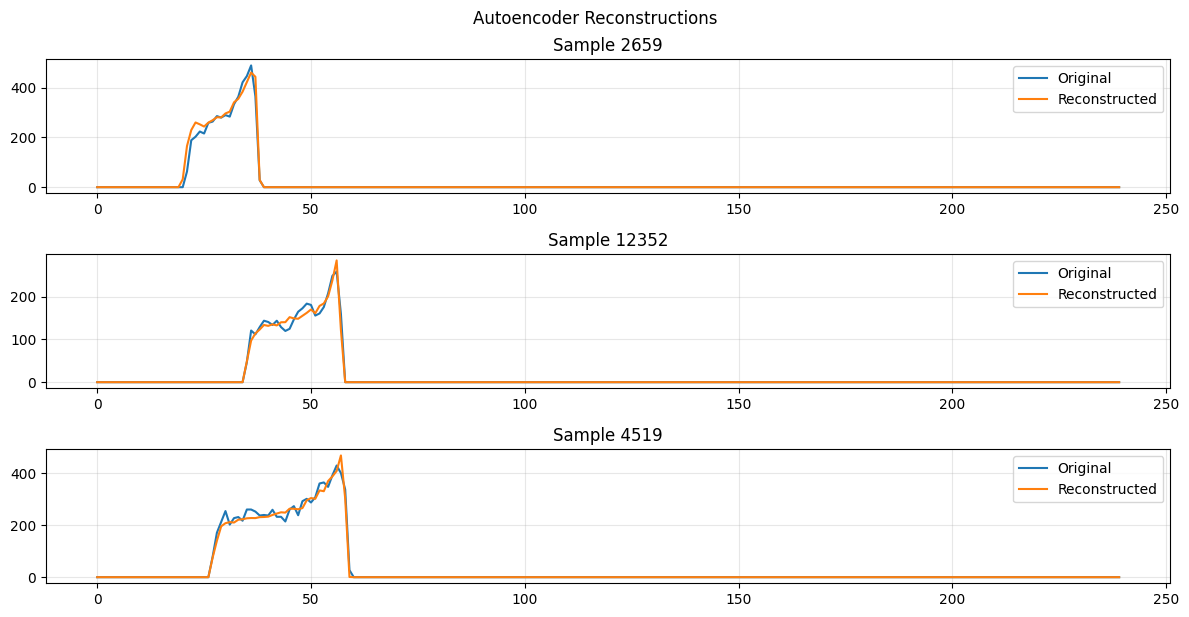

In [175]:
plt.figure(figsize=(12, 2 * N))

for i in range(N):
    plt.subplot(N, 1, i + 1)
    plt.plot(samples[i].cpu().numpy(), label="Original")
    plt.plot(recons[i].cpu().numpy(), label="Reconstructed")
    plt.title(f"Sample {indices[i].item()}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Autoencoder Reconstructions", y=1.02)
plt.show()


In [110]:
model.eval()
with torch.no_grad():
    recons = model(X)  # same shape as X
    per_sample_mse = F.mse_loss(recons, X, reduction='none')  # shape: [N, 240]
    RE = per_sample_mse.mean(dim=1).cpu().numpy()  # shape: [N,]

In [ ]:
top_n = 3
highest_RE_indices = np.argsort(-RE)[:top_n]

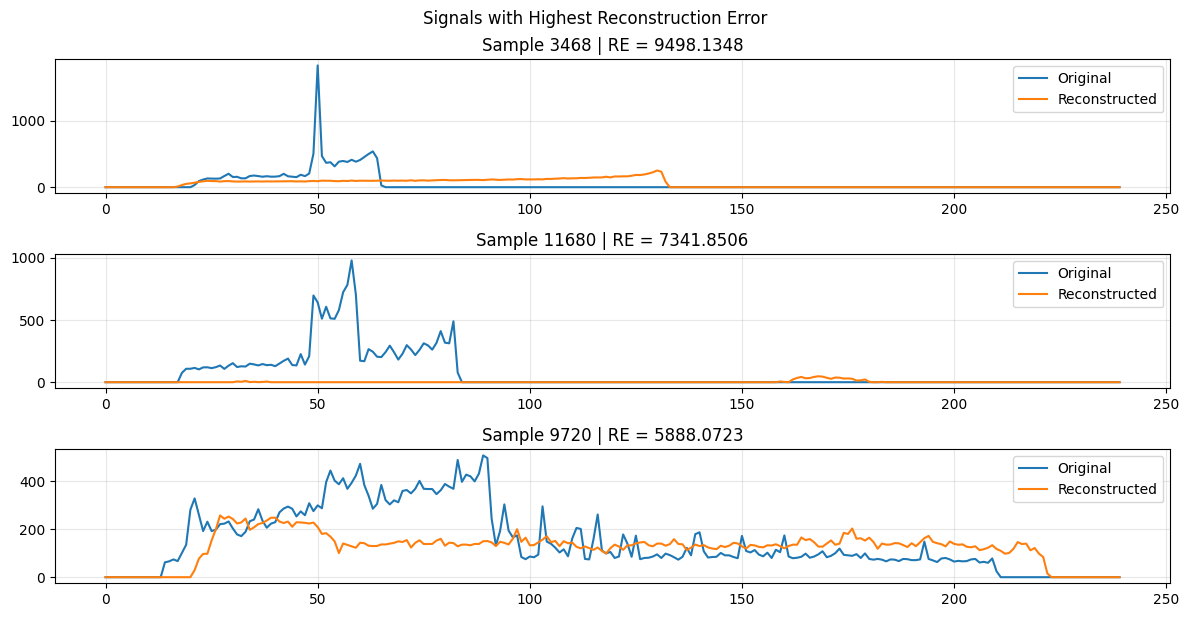

In [154]:
plt.figure(figsize=(12, 2 * top_n))
for i, idx in enumerate(highest_RE_indices):
    plt.subplot(top_n, 1, i + 1)
    plt.plot(X[idx].cpu().numpy(), label='Original')
    plt.plot(recons[idx].cpu().numpy(), label='Reconstructed')
    plt.title(f"Sample {idx} | RE = {RE[idx]:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Signals with Highest Reconstruction Error", y=1.02)
plt.show()

Checking on deuteron dataset.

In [79]:
Y = torch.tensor(padded_deuterons, dtype=torch.float32)

In [80]:
model.eval()
with torch.no_grad():
    recons_new = model(Y)

In [81]:
import torch.nn.functional as F

re = F.mse_loss(recons_new, Y, reduction='none')  # (N, 240)
RE_per_sample = re.mean(dim=1).cpu().numpy()  # shape (N,)


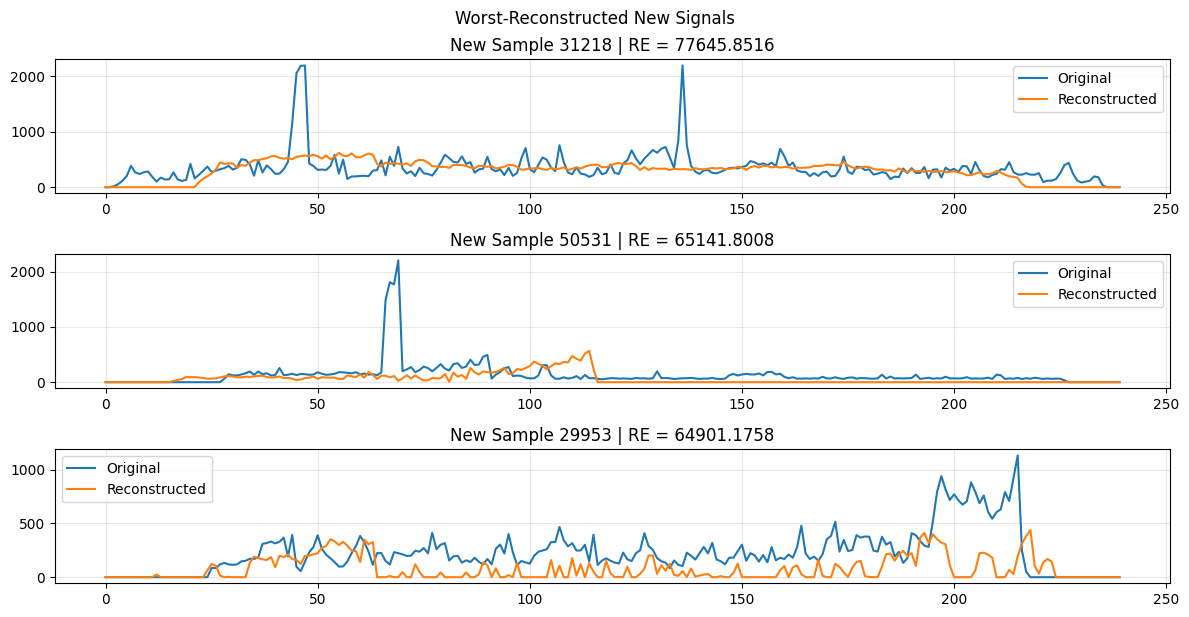

In [149]:
top_n = 3
worst_indices = np.argsort(-RE_per_sample)[:top_n]

plt.figure(figsize=(12, 2 * top_n))
for i, idx in enumerate(worst_indices):
    plt.subplot(top_n, 1, i + 1)
    plt.plot(Y[idx].squeeze().cpu().numpy(), label='Original')
    plt.plot(recons_new[idx].squeeze().cpu().numpy(), label='Reconstructed')
    plt.title(f"New Sample {idx} | RE = {RE_per_sample[idx]:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Worst-Reconstructed New Signals", y=1.02)
plt.show()

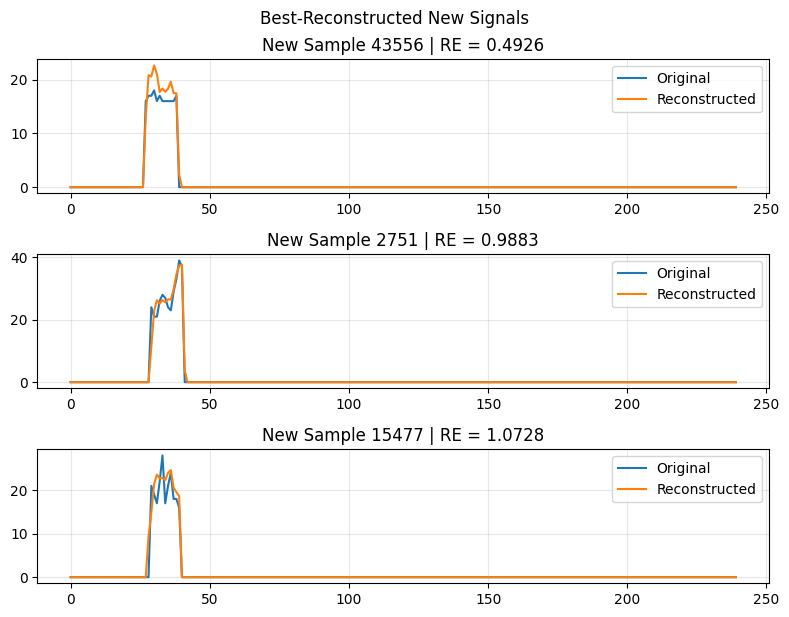

In [148]:
# Get indices of best-reconstructed samples (lowest RE)
best_n = 3
best_indices = np.argsort(RE_per_sample)[:best_n]  # ascending order

# Plot
plt.figure(figsize=(8, 2 * best_n))
for i, idx in enumerate(best_indices):
    plt.subplot(best_n, 1, i + 1)
    plt.plot(Y[idx].squeeze().cpu().numpy(), label='Original')
    plt.plot(recons_new[idx].squeeze().cpu().numpy(), label='Reconstructed')
    plt.title(f"New Sample {idx} | RE = {RE_per_sample[idx]:.4f}")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle("Best-Reconstructed New Signals", y=1.02)
plt.show()


In [156]:
import torch.nn.functional as F

model.eval()
with torch.no_grad():
    recons = model(Y)  # X shape: (N, 240)
    mse = F.mse_loss(recons, Y, reduction='none')  # shape (N, 240)
    RE_per_sample = mse.mean(dim=1).cpu().numpy()  # shape (N,)

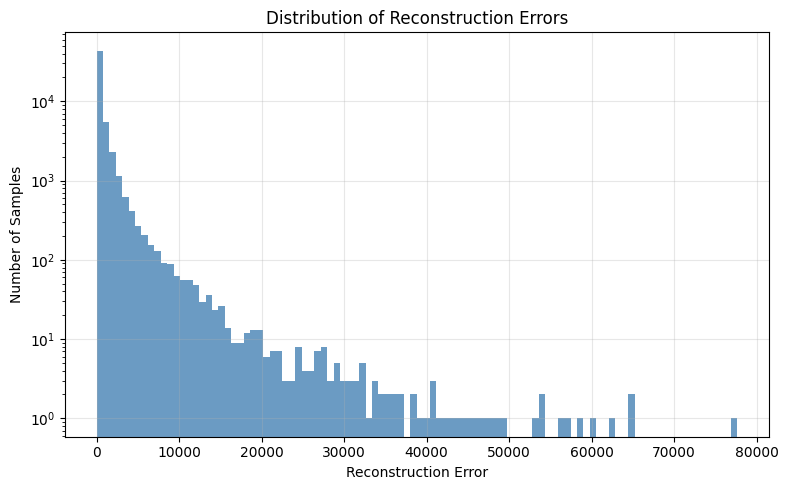

In [172]:
plt.figure(figsize=(8, 5))
plt.hist(RE_per_sample, bins=100, color='steelblue', alpha=0.8)
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Samples")
plt.title("Distribution of Reconstruction Errors")
plt.grid(True, alpha=0.3)
plt.yscale('log')  # optional
plt.tight_layout()
plt.show()